# Line up BOLD data and Labels

### Goals of this script
1. import labels (already trimmed but not shifted)
2. shift labels to account for hemodynamic lag
3. load voxel x TR matrix for ROI(s) of interest
4. reshape data (remove all fixation timepoints)
5. export BOLD data and matched labels 

## Define subject

In [1]:
sub = 'sub-005'
subNum = '005'
ses = 'ses-01'
task = 'localizer'
run = 10

ROIs=['bilateral_hippo','bilateral_oc-temp']

## Import necessary packages

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
import nilearn
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_roi
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import scipy.io
#from mpi4py import MPI
import os
import pickle 
import time
from scipy.sparse import random
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from pathlib import Path
from shutil import copyfile
import seaborn as sns
import importlib
import csv

# Import machine learning libraries
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [3]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The nilearn version is {}.'.format(nilearn.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The python version is 3.9.10.
The scikit-learn version is 1.0.2.
The numpy version is 1.20.3.
The nilearn version is 0.8.1.
The seaborn version is 0.11.2.


In [4]:
#find out how much to trunc from beginning and end
file_name = '/jukebox/norman/karina/adderzip_fMRI/adderzip/data/supanalysis/TR_count/TR_count_%s.csv' % (subNum)

countData = open(file_name)
countData = csv.reader(countData)
countData = list(countData)
countData = countData[1::]
countData = np.array(countData)
countData = np.float64(countData)

n_trunc_beginning= int(countData[run-1,1])#Number of volumes to trim from beginning of this run
n_trunc_end= int(countData[run-1,3]) #Number of volumes to trim from end of run

## Load settings

In [31]:
# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/analysis/mainanalysis')
import adderzip_utils
from adderzip_utils import load_adderzip_stim_labels_localizer,load_adderzip_epi_data, shift_timing, label2TR, mask_data

importlib.reload(adderzip_utils)

# load some constants
from adderzip_utils import adderzip_dir, adderzip_bids_dir, adderzip_label_dict, n_runs, run_names, adderzip_TR, adderzip_hrf_lag, TRs_run

print('TASKS:', task)
print('LIST OF ALL TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_localizer = n_runs[task_index]

TRs_run_localizer=TRs_run[task_index]-n_trunc_beginning-n_trunc_end

trials_run_localizer = 90

anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/%s/' % sub
mask_fold = adderzip_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
#mask_fold_hipp = adderzip_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
data_dir='/jukebox/norman/karina/adderzip_fMRI/adderzip/data/mainanalysis/output'

#ses0_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/ses-00/func/' % sub
ses1_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/ses-01/func/' % sub
#ses2_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/ses-02/func/' % sub

print('bids dir = %s' % (adderzip_bids_dir))
print('')
print('subject dir = %s' % (ses1_dir))
print('')
print('output dir = %s' % (out_dir))
print('')
print('ROIs = %s' % (ROIs))
print('Labels = %s' % (adderzip_label_dict))
print('number of runs = %d' % (n_runs_localizer))
print('TR = %s seconds' % (adderzip_TR))
print('TRs per run before trimming = %s' % (TRs_run[task_index]))
print('%d volumes trimmed from beginning of each run' % (n_trunc_beginning))
print('%d volumes trimmed from end of each run depending on n_trunc_end file'% (n_trunc_end))
print('TRs per run after trimming = %s' % (TRs_run_localizer))

TASKS: localizer
LIST OF ALL TASKS: ['localizer']
task index: 0

bids dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/

subject dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/fmriprep/sub-007/ses-01/func/

output dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-007/

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects', 0: 'Rest'}
number of runs = 3
TR = 1.5 seconds
TRs per run before trimming = 194
14 volumes trimmed from beginning of each run
10 volumes trimmed from end of each run depending on n_trunc_end file
TRs per run after trimming = 170


## Stimulus labels  - load truncated stimulus labels and shift labels 4.5 sec (3 TRs)

stim_label has shape:  (91, 8)

stim_label looks like this
[['# trial' 'run' 'block' 'imCat' 'repeat' 'imID' 'targetOnset'
  'targetOffset']
 ['0' '0' '0' '2' '0' '1' '15.000000' '16.500000']
 ['1' '0' '0' '2' '0' '2' '16.500000' '18.000000']
 ['2' '0' '0' '2' '1' '2' '18.000000' '19.500000']
 ['3' '0' '0' '2' '0' '3' '19.500000' '21.000000']]
...
[['85' '0' '8' '1' '0' '21' '262.500000' '264.000000']
 ['86' '0' '8' '1' '0' '22' '264.000000' '265.500000']
 ['87' '0' '8' '1' '1' '22' '265.500000' '267.000000']
 ['88' '0' '8' '1' '0' '23' '267.000000' '268.500000']
 ['89' '0' '8' '1' '0' '24' '268.500000' '270.000000']]


Text(0.5, 0, 'Trial')

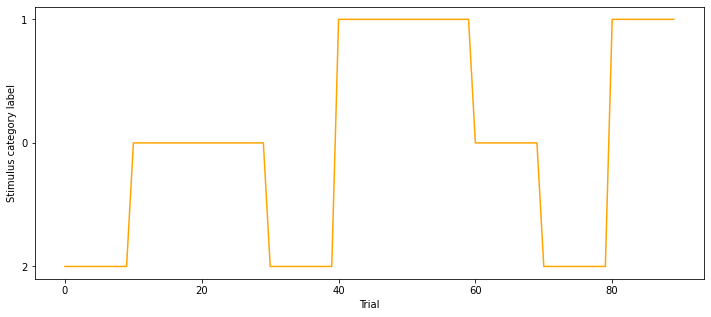

In [57]:
# load stimulus labels from regressor file for each run and concatenate
# NOTE: Regressor files are already trimmed (beginning only), but not shifted, in Matlab using gen_loc_regressor_0101.m

stim_label = load_adderzip_stim_labels_localizer(subNum,run)
        
print('stim_label has shape: ', np.shape(stim_label))
print('')
print('stim_label looks like this')
print(stim_label[:5,:])
print('...')
print(stim_label[-5:,:])


# Plot the labels
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label[1:,3], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('Trial')

original shape (91, 8)
new shape after adding new column with changesd imCat labels (91, 9)
new shape after adding new column with 7.5 sec delay (91, 10)
new shape after adding new column with trimmed TRs (91, 11)
new shape after adding new column with continuous TRs (91, 12)

stim_label looks like this
[['# trial' 'run' 'block' 'imCat' 'repeat' 'imID' 'targetOnset'
  'targetOffset' '0.0' '0.0' '0.0' '0.0']
 ['0' '0' '0' '2' '0' '1' '15.000000' '16.500000' '3.0' '21.0' '0.0'
  '0.0']
 ['1' '0' '0' '2' '0' '2' '16.500000' '18.000000' '3.0' '22.5' '1.0'
  '1.0']
 ['2' '0' '0' '2' '1' '2' '18.000000' '19.500000' '3.0' '24.0' '2.0'
  '2.0']
 ['3' '0' '0' '2' '0' '3' '19.500000' '21.000000' '3.0' '25.5' '3.0'
  '3.0']]
...
[['85' '0' '8' '1' '0' '21' '262.500000' '264.000000' '2.0' '268.5'
  '165.0' '165.0']
 ['86' '0' '8' '1' '0' '22' '264.000000' '265.500000' '2.0' '270.0'
  '166.0' '166.0']
 ['87' '0' '8' '1' '1' '22' '265.500000' '267.000000' '2.0' '271.5'
  '167.0' '167.0']
 ['88' '0' 

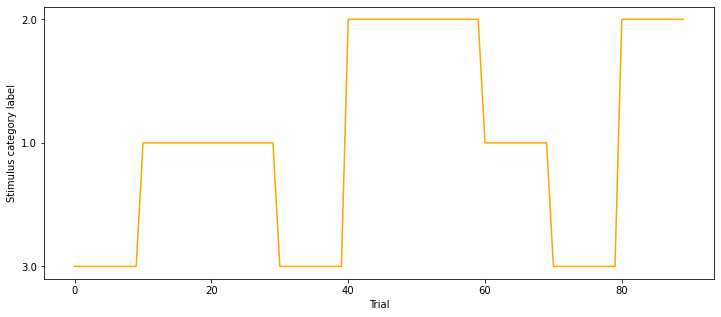

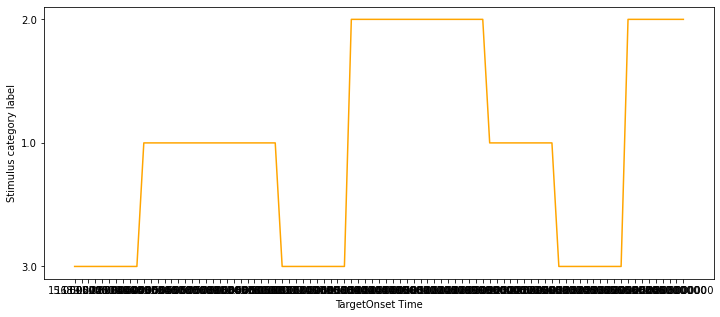

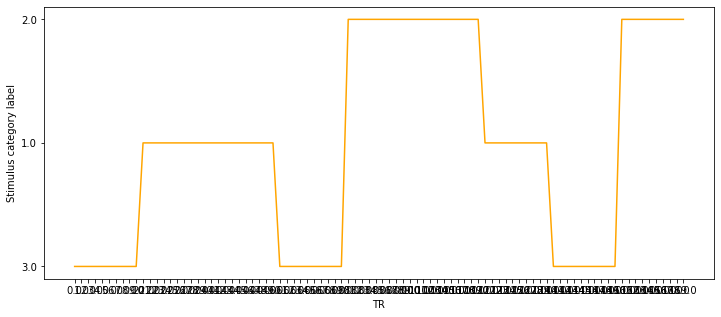

In [58]:
#reshape and edit stim labels format
print('original shape', np.shape(stim_label))

#image category is 0, 1, 2. change to 1,2,3
if stim_label.shape[1]==8:
    imCat = stim_label[1:,3] 
    ones = np.ones(int(np.shape(imCat)[0]))
    ones = np.float64(ones)
    imCat = np.float64(imCat)
    newCol_imCat = imCat + ones
    zeros = np.zeros((int(np.shape(imCat)[0]+1),1))
    stim_label = np.hstack((stim_label,zeros))
    stim_label[1:,8] = newCol_imCat

    print('new shape after adding new column with changesd imCat labels', np.shape(stim_label))

# Plot the labels
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label[1:,8], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('Trial')

# Plot the labels for 1st run
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label[1:90,6],stim_label[1:90,8], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TargetOnset Time')

#targetOnset has an error. Fix by adding 7.5sec delay
if stim_label.shape[1]==9:
    stim_label = np.hstack((stim_label,zeros))
    
    targetOnset = np.float64(stim_label[1:,6])
    ones = np.ones(stim_label.shape[0]-1)
    delay = np.float64(ones * 6)
    newTargetOnset = targetOnset + delay
    
    #print('newCol_targetOnset',newCol_targetOnset)
    stim_label[1:,9] = newTargetOnset

    print('new shape after adding new column with 7.5 sec delay', np.shape(stim_label))

#change targetOnset time to TR
#truncate initial 
if stim_label.shape[1]==10:
    stim_label = np.hstack((stim_label,zeros))
    newCol_TR = np.float64(stim_label[1:,9])
    newCol_TR = newCol_TR / np.float64(adderzip_TR)
    
    newCol_TR = newCol_TR - np.float64(ones * n_trunc_beginning)
    
    stim_label[1:,10] = newCol_TR

    print('new shape after adding new column with trimmed TRs', np.shape(stim_label))

#targetOnset starts count at each run. Make it continuous
if stim_label.shape[1]==11:
    stim_label = np.hstack((stim_label,zeros))
    
    #eachRun = run-10
    #TRs_thisRun = np.float64(stim_label[1:,10])
    #newCol_TRs = TRs_thisRun + TRs_run_localizer*eachRun
    newCol_TRs = np.float64(stim_label[1:,10])
        
    stim_label[1:,11] = newCol_TRs
    
    print('new shape after adding new column with continuous TRs', np.shape(stim_label))

# Plot the labels 
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label[1:,11],stim_label[1:,8], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')

print('')
print('stim_label looks like this')
print(stim_label[:5,:])
print('...')
print(stim_label[-5:,:])


shift by 3 TRs
TRs [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  20.  21.  22.  23.
  24.  25.  26.  27.  28.  29.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 160. 161. 162. 163.
 164. 165. 166. 167. 168. 169.]
shiftedTRs [  3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172.]
stim_label_shifted shape (91, 12)

stim_label_shifted 

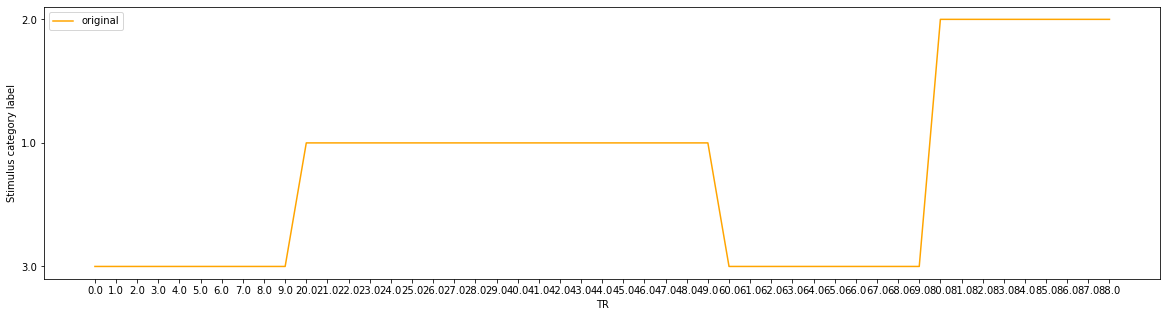

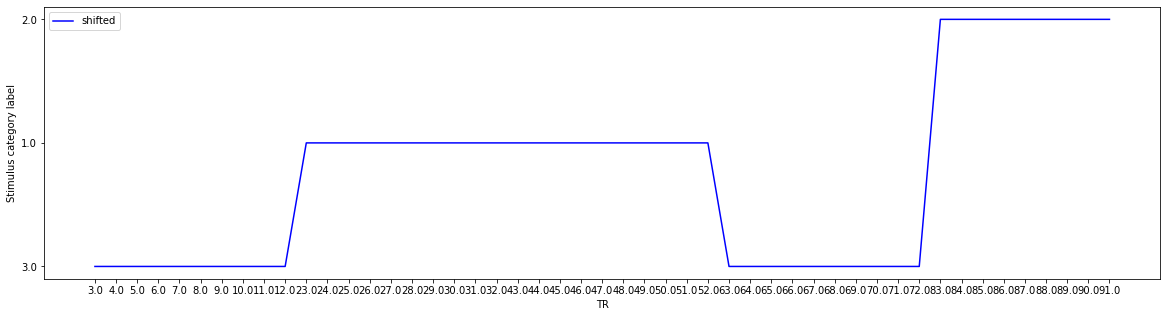

In [59]:
# Shift the data labels to account for hemodynamic lag
shift_size = int(adderzip_hrf_lag / adderzip_TR)  # Convert the shift into TRs
print('shift by %s TRs' % (shift_size))

#add shift to TRs
TRs = stim_label[1:,11] 
ones = np.ones(int(np.shape(TRs)[0]))
shiftBy = ones * shift_size
shiftBy = np.float64(shiftBy)
TRs = np.float64(TRs)
shiftedTRs = TRs + shiftBy
#print('TRs',TRs)
#print('shiftedTRs',shiftedTRs)
shiftBy = int(shift_size) 
shiftedTRs[-shiftBy:] = 0
stim_label_shifted = np.copy(stim_label)
stim_label_shifted[1:,11] = shiftedTRs


# Plot the original and shifted labels
f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(stim_label[1:50,10],stim_label[1:50,8], label='original', c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(stim_label_shifted[1:50,11],stim_label_shifted[1:50,8], label='shifted', c='blue')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

print('stim_label_shifted shape', np.shape(stim_label_shifted))
np.savetxt('/jukebox/norman/karina/adderzip_fMRI/adderzip/data/behavioral/info_processed_v1/locInfo/locInfo_'+subNum+'.csv',stim_label_shifted[1:,:],fmt='%10s',delimiter=",")

print('')
print('stim_label_shifted looks like this')
print(stim_label_shifted[:5,:])
print(stim_label_shifted[-5:,:])

## OR if voxel x TR matrix already exists, load matrix:

In [51]:
# load defaced T1 image (merged T1 from fmriprep)
t1_file = anat_dir + sub +'_' +ses + '_desc-preproc_T1w_defaced.nii.gz'
t1_img = image.load_img(t1_file) 

# Make a function to load the mask data
def load_adderzip_mask(ROI_name, sub):
    """Load the mask for the svd data 
    Parameters
    ----------
    ROI_name: string
    sub: string 
    
    Return
    ----------
    the requested mask
    """    
    # load the mask
    #if ROI_name == 'bilateral_hippo':
        #mask_fold=mask_fold_other
    #else:
        #mask_fold=mask_fold_hipp
    maskfile = (mask_fold + sub + "_%s.nii.gz" % (ROI_name))
    mask = nib.load(maskfile)
    print("Loaded mask: %s" % (ROI_name))
    return mask

Loaded mask: bilateral_hippo
Loaded mask: bilateral_oc-temp


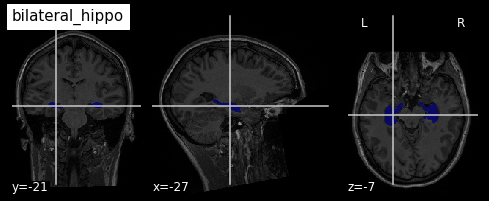

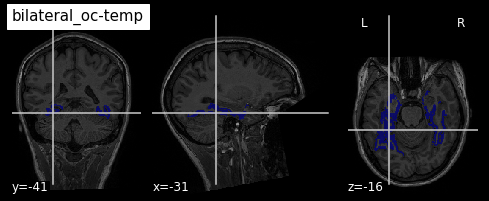

In [53]:
# load voxel x TR data for each ROI
mask_list = ROIs
masked_data = []
masked_data_all = [0] * len(mask_list)

for mask_counter in range(len(mask_list)):
    # load the mask for the corresponding ROI
    this_mask = mask_list[mask_counter]

    #if this_mask == 'bilateral_hippo':
    #    mask_fold=mask_fold_other
    #else:
        #mask_fold=mask_fold_hipp

    mask = load_adderzip_mask(mask_list[mask_counter], sub)

    # plot mask overlayed on subject's T1
    plot_roi(mask, bg_img=t1_img, title=this_mask)

    # Load in data from matlab
    in_file = (adderzip_bids_dir + 'derivatives/firstlevel/%s/masked_epi_data_v1/threshold-75/%s_task-%s_run-0%i_space-T1w_trim%dandEndTRs_mask-%s.mat' % (sub, sub, task, run, n_trunc_beginning, this_mask))
    masked_data = scipy.io.loadmat(in_file);
    masked_data = np.array(masked_data['data']);
    masked_data_all[mask_counter] = masked_data

voxel by TR matrix - shape:  bilateral_hippo (2476, 170)
voxel by TR matrix - shape:  bilateral_oc-temp (7187, 170)


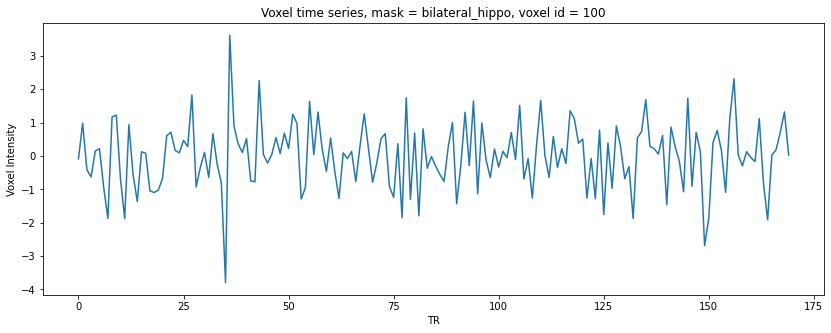

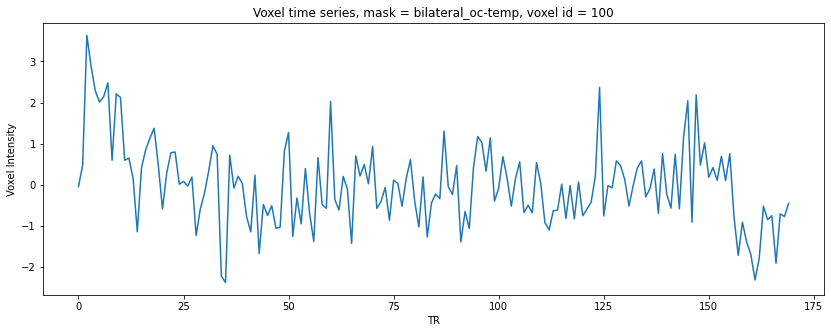

In [54]:
# check dimensionality of the data and plot value of voxel_id across timeseries; make sure data are z-scored 
num_voxels = [0] * len(mask_list)

voxel_id = 100
for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print('voxel by TR matrix - shape: ', this_mask, masked_data_all[mask_counter].shape)
    num_voxels[mask_counter] = masked_data_all[mask_counter].shape[0] #save number of voxels in each mask
    
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(masked_data_all[mask_counter][voxel_id,:])

    ax.set_title('Voxel time series, mask = %s, voxel id = %d' % (this_mask, voxel_id))
    ax.set_xlabel('TR')
    ax.set_ylabel('Voxel Intensity')
    

## Reshape labels and data 
Extract the time points for which we have stimulus labels. For classifier B, we remove all rest TRs. 

In [62]:
# Extract bold data for non-zero labels
print('label list - shape: ', stim_label_shifted[1:,:].shape)

def reshape_data(stim_label_allruns_shifted, masked_data_roi):
    label_index = np.float64(stim_label_shifted[1:,11])
    label_index = label_index.astype(int)
    print(label_index)
    
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_roi[:,label_index])
    nonzero_labels = stim_label_shifted[1:,8]
    return indexed_data, nonzero_labels

# Pull out the data from this ROI for these time points

bold_data_reshaped = [0] * len(mask_list)

for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    #print(this_mask)

    masked_data_roi = masked_data_all[mask_counter]

    bold_data, labels = reshape_data(stim_label_shifted, masked_data_roi)

    bold_data_reshaped[mask_counter] = bold_data

    # What is the dimensionality of the data? We need the first dim to be the same
    print('The %s has the dimensionality of: %d time points by %d voxels' % (this_mask, bold_data.shape[0], bold_data.shape[1]))

    print(labels)

    print('bold data for ',this_mask,'has shape',bold_data.shape)
    print('')
    print('bold data for ',this_mask,'looks like this')
    print(bold_data[:5,:])
    print('...')
    print(bold_data[-5:,:])

    np.savetxt(data_dir+'/bold_data_localizer/'+this_mask+'/bold_run-0'+str(run)+'_'+subNum+'.csv', bold_data, fmt='%f', delimiter=",")
    
    labels = np.float64(labels)
    np.savetxt(data_dir+'/label_list_localizer/labels_run-0'+str(run)+'_'+subNum+'.csv', labels, fmt='%f', delimiter=",")

label list - shape:  (90, 12)
[  3   4   5   6   7   8   9  10  11  12  23  24  25  26  27  28  29  30
  31  32  43  44  45  46  47  48  49  50  51  52  63  64  65  66  67  68
  69  70  71  72  83  84  85  86  87  88  89  90  91  92 103 104 105 106
 107 108 109 110 111 112 123 124 125 126 127 128 129 130 131 132 143 144
 145 146 147 148 149 150 151 152 163 164 165 166 167 168 169   0   0   0]
The bilateral_hippo has the dimensionality of: 90 time points by 2476 voxels
['3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '1.0' '1.0'
 '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0'
 '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '3.0' '3.0' '3.0' '3.0' '3.0' '3.0'
 '3.0' '3.0' '3.0' '3.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0'
 '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0' '2.0'
 '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '3.0' '3.0'
 '3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '3.0' '2.0' '2.0' '2.0' '2.0'
 '2.0' '2.0' '2.

In [23]:
# How many labels corresponding to each category? 
print('Labels = %s' % (adderzip_label_dict))
#find_zeros = np.where(labels[1:,:] == 0)[0] #to double check that numbers line up
find_ones = np.where(labels[:] == '1.0')[0] #to double check that numbers line up
find_twos = np.where(labels[:] == '2.0')[0] #to double check that numbers line up
find_threes = np.where(labels[:] == '3.0')[0] #to double check that numbers line up
#print("number of rest timepoints:", find_zeros.shape[0])
print(find_ones)
print("number of face timepoints:", len(find_ones))
print("number of scene timepoints:", len(find_twos))
print("number of object timepoints:", len(find_threes))

Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects', 0: 'Rest'}
[]
number of face timepoints: 0
number of scene timepoints: 0
number of object timepoints: 0


## Run classifier - linear SVC
Feed train set and get get accuracy back for test set

In [13]:
run1_bold = bold_data[0:90,:]
run1_labels = labels[0:90]

run2_bold = bold_data[90:180,:]
run2_labels = labels[90:180]

run3_bold = bold_data[180:270,:]
run3_labels = labels[180:270]

fold1_bold_train = np.vstack((run1_bold,run2_bold))
fold1_labels_train = np.hstack((run1_labels,run2_labels))

fold1_bold_test = run3_bold
fold1_labels_test = run3_labels

fold2_bold_train = np.vstack((run2_bold,run3_bold))
fold2_labels_train = np.hstack((run2_labels,run3_labels))

fold2_bold_test = run1_bold
fold2_labels_test = run1_labels

fold3_bold_train = np.vstack((run1_bold,run3_bold))
fold3_labels_train = np.hstack((run1_labels,run3_labels))

fold3_bold_test = run2_bold
fold3_labels_test = run2_labels

def classifier_linearSVC(bold_train, labels_train, bold_test, labels_test):
    # normalize the data 
    scaler = StandardScaler()
    bold_train = scaler.fit_transform(bold_train)
    bold_test = scaler.transform(bold_test)

    # Create a classifier model for the training set 
    model = LinearSVC(C=1)

    # Fit the model
    model.fit(bold_train, labels_train)

    # Compute your evaluation on the test set
    score = model.score(bold_test, labels_test)
    print('Accuracy = %s' % score)
    
    return score

print('fold 1')
fold1_score = classifier_linearSVC(fold1_bold_train, fold1_labels_train, fold1_bold_test, fold1_labels_test)

print('fold 2')
fold2_score = classifier_linearSVC(fold2_bold_train, fold2_labels_train, fold2_bold_test, fold2_labels_test)

print('fold 3')
fold3_score = classifier_linearSVC(fold3_bold_train, fold3_labels_train, fold3_bold_test, fold3_labels_test)


fold 1
Accuracy = 0.5222222222222223
fold 2
Accuracy = 0.7555555555555555
fold 3


KeyboardInterrupt: 

In [ ]:
print('train on 1, test on 2')
classifier_linearSVC(run1_bold,run1_labels,run2_bold,run2_labels)

print('train on 2, test on 3')
classifier_linearSVC(run2_bold,run2_labels,run3_bold,run3_labels)

print('train on 1, test on 3')
classifier_linearSVC(run1_bold,run1_labels,run3_bold,run3_labels)

print('train on 2, test on 1')
classifier_linearSVC(run2_bold,run2_labels,run1_bold,run1_labels)

## Run classifier - logistic regression
Feed train set and get probability back for test set

In [24]:
def classifier(bold_train, labels_train, bold_test, labels_test, model,linReg):
    # normalize the data 
    scaler = StandardScaler()
    bold_train = scaler.fit_transform(bold_train)
    bold_test = scaler.fit_transform(bold_test)


    # Fit the model
    model.fit(bold_train, labels_train)

    # Compute your evaluation on the test set
    score = model.score(bold_test, labels_test)
    print('Accuracy = %s' % score)
    
    if linReg == 1:
        prediction = model.predict(bold_test)
        prediction_prob = model.predict_proba(bold_test)
    else:
        prediction = 'NA'
        prediction_prob = 'NA'
    
    return score, prediction, prediction_prob

model_linearSVC = LinearSVC(C=1)
model_linReg_1 = LogisticRegression(C=1.0, random_state=34, solver='liblinear')

In [25]:
def split(bold_data,labels,trials_run_localizer):
    
    run1_bold = bold_data[0:trials_run_localizer,:]
    run1_labels = labels[0:trials_run_localizer]

    run2_bold = bold_data[trials_run_localizer:(trials_run_localizer*2),:]
    run2_labels = labels[trials_run_localizer:(trials_run_localizer*2)]

    run3_bold = bold_data[(trials_run_localizer*2):(trials_run_localizer*3),:]
    run3_labels = labels[(trials_run_localizer*2):(trials_run_localizer*3)]

    fold1_bold_train = np.vstack((run2_bold,run3_bold))
    fold1_labels_train = np.hstack((run2_labels,run3_labels))

    fold1_bold_test = run1_bold
    fold1_labels_test = run1_labels

    fold2_bold_train = np.vstack((run1_bold,run3_bold))
    fold2_labels_train = np.hstack((run1_labels,run3_labels))

    fold2_bold_test = run2_bold
    fold2_labels_test = run2_labels

    fold3_bold_train = np.vstack((run1_bold,run2_bold))
    fold3_labels_train = np.hstack((run1_labels,run2_labels))

    fold3_bold_test = run3_bold
    fold3_labels_test = run3_labels
    
    return fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test

In [53]:
#split data
fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels,trials_run_localizer)

#check if linear SVC is working in the same way
score,prediction,prediction_prob = classifier(fold1_bold_train, fold1_labels_train, fold1_bold_test, fold1_labels_test,model_linearSVC,0)
score,prediction,prediction_prob = classifier(fold2_bold_train, fold2_labels_train, fold2_bold_test, fold2_labels_test,model_linearSVC,0)
score,prediction,prediction_prob = classifier(fold3_bold_train, fold3_labels_train, fold3_bold_test, fold3_labels_test,model_linearSVC,0)

#try linear regression 
score,prediction,prediction_prob = classifier(fold1_bold_train, fold1_labels_train, fold1_bold_test, fold1_labels_test,model_linReg_1,1)
score,prediction,prediction_prob = classifier(fold2_bold_train, fold2_labels_train, fold2_bold_test, fold2_labels_test,model_linReg_1,1)
score,prediction,prediction_prob = classifier(fold3_bold_train, fold3_labels_train, fold3_bold_test, fold3_labels_test,model_linReg_1,1)


#print('prediction=',prediction)
#print('prediction probability=',prediction_prob)

Accuracy = 0.5222222222222223
Accuracy = 0.7555555555555555
Accuracy = 0.5666666666666667
Accuracy = 0.4888888888888889
Accuracy = 0.7666666666666667
Accuracy = 0.6666666666666666


Accuracy = 0.7444444444444445
Accuracy = 0.6222222222222222
Accuracy = 0.5
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[0.48 0.48 0.5  0.49 0.5  0.5  0.5  0.24 0.44 0.94 0.64 0.61 0.5  0.65
 0.63 0.78 0.49 0.34 0.25 0.3  0.   0.01 0.01 0.   0.02 0.01 0.   0.02
 0.01 0.68 0.34 0.   0.1  0.16 0.01 0.03 0.02 0.01 0.01 0.58 0.07 0.05
 0.05 0.   0.   0.01 0.   0.   0.   0.   0.99 0.99 0.98 0.91 0.97 0.65
 0.78 0.74 0.06 0.   0.82 0.66 0.45 0.3  0.53 0.66 0.48 0.41 0.92 0.98
 0.22 0.02 0.23 0.31 0.02 0.44 0.42 0.56 0.02 0.   0.25 0.98 0.99 0.96
 0.98 0.27 0.27 0.   0.   0.  ]


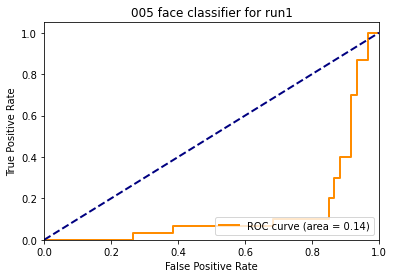

Accuracy = 0.7444444444444445
Accuracy = 0.6222222222222222
Accuracy = 0.5


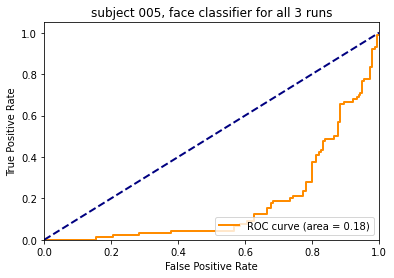

NameError: name 'labels_scene' is not defined

In [29]:
# binary classification of category vs. not category
n_classifierTypes = 3
totalTrials = trials_run_localizer * n_runs_localizer * n_classifierTypes
partiData = np.zeros((totalTrials,6))

#subject
partiData[:,0] = subNum

#classifier type
ones_c = np.ones(trials_run_localizer* n_runs_localizer)
twos_c = np.ones(trials_run_localizer* n_runs_localizer)*2
threes_c = np.ones(trials_run_localizer* n_runs_localizer)*3
classiCol = np.hstack((ones_c,twos_c,threes_c))
partiData[:,1] = classiCol

#run
ones = np.ones(trials_run_localizer)
twos = np.ones(trials_run_localizer)*2
threes = np.ones(trials_run_localizer)*3
runCol = np.hstack((ones,twos,threes))
runCol = np.tile(runCol, n_classifierTypes)
partiData[:, 2] = runCol

#TR
TRs_oneRun = np.arange(1,(trials_run_localizer+1))
TRsCol = np.tile(TRs_oneRun,n_runs_localizer)
TRsCol = np.tile(TRsCol,n_classifierTypes)
partiData[:,3] = TRsCol

# print('partiData')
# print(partiData.shape)
# print(partiData)

#face vs. non-face
labels_face = np.copy(labels)
labels_face[find_ones] = 1
labels_face[find_twos] = 0
labels_face[find_threes] = 0

fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels_face,trials_run_localizer)

fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)


y_true = fold1_labels_test
#y_true = partiData[start:(start + trials_run_localizer * n_runs_localizer),4]
y_true = list(y_true)
print(y_true)
y_scores = fold1_prediction_prob[:,1]
#y_scores = partiData[start:(start + trials_run_localizer * n_runs_localizer),5]
print(y_scores)
fpr,tpr,threshold = roc_curve(y_true,y_scores,pos_label=1)

roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title='%s face classifier for run1' % (subNum)
plt.title(title)
plt.legend(loc="lower right")
plt.show()
    
# partiData[0:trials_run_localizer,4] = fold1_labels_test
# partiData[trials_run_localizer:(trials_run_localizer*2),4] = fold2_labels_test
# partiData[(trials_run_localizer*2):(trials_run_localizer*3),4] = fold3_labels_test

# partiData[0:trials_run_localizer,5] = fold1_prediction_prob[:,1]
# partiData[trials_run_localizer:(trials_run_localizer*2),5] = fold2_prediction_prob[:,1]
# partiData[(trials_run_localizer*2):(trials_run_localizer*3),5] = fold3_prediction_prob[:,1]

# # print('partiData')
# # print(partiData.shape)
# # print(partiData)

# #scene vs. non-scene
# labels_scene = np.copy(labels)
# labels_scene[find_ones] = 0
# labels_scene[find_twos] = 1
# labels_scene[find_threes] = 0

# fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels_scene,trials_run_localizer)

# fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
# fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
# fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)

# partiData[270:(270+trials_run_localizer),4] = fold1_labels_test
# partiData[(270+trials_run_localizer):(270+trials_run_localizer*2),4] = fold2_labels_test
# partiData[(270+trials_run_localizer*2):(270+trials_run_localizer*3),4] = fold3_labels_test

# partiData[270:(270+trials_run_localizer),5] = fold1_prediction_prob[:,1]
# partiData[(270+trials_run_localizer):(270+trials_run_localizer*2),5] = fold2_prediction_prob[:,1]
# partiData[(270+trials_run_localizer*2):(270+trials_run_localizer*3),5] = fold3_prediction_prob[:,1]

# #object vs. non-object
# labels_object = np.copy(labels)
# labels_object[find_ones] = 0
# labels_object[find_twos] = 0
# labels_object[find_threes] = 1

# fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels_object,trials_run_localizer)

# fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
# fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
# fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)

# partiData[540:(540+trials_run_localizer),4] = fold1_labels_test
# partiData[(540+trials_run_localizer):(540+trials_run_localizer*2),4] = fold2_labels_test
# partiData[(540+trials_run_localizer*2):(540+trials_run_localizer*3),4] = fold3_labels_test

# partiData[540:(540+trials_run_localizer),5] = fold1_prediction_prob[:,1]
# partiData[(540+trials_run_localizer):(540+trials_run_localizer*2),5] = fold2_prediction_prob[:,1]
# partiData[(540+trials_run_localizer*2):(540+trials_run_localizer*3),5] = fold3_prediction_prob[:,1]

#print('partiData')
#print(partiData.shape)
#print(partiData)


#print(fold1_labels_test.shape)
#print(fold1_prediction)
#print(fold1_prediction_prob[:,1].shape)

for eachClassi in range(n_classifierTypes):
    
    if eachClassi == 0:
        labels = labels_face
        classiType = 'face'
    elif eachClassi == 1:
        labels = labels_scene
        classiType = 'scene'
    elif eachClassi == 2:
        labels = labels_object
        classiType = 'object'
    
    fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels,trials_run_localizer)

    fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
    fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
    fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)
    
    start = eachClassi * trials_run_localizer * n_runs_localizer
    end = eachClassi * trials_run_localizer * n_runs_localizer + trials_run_localizer
    
    partiData[start:end,4] = fold1_labels_test      
    partiData[(start+trials_run_localizer):(end+trials_run_localizer),4] = fold2_labels_test
    partiData[(start+trials_run_localizer*2):(end+trials_run_localizer*2),4] = fold3_labels_test

    partiData[start:end,5] = fold1_prediction_prob[:,1]
    partiData[(start+trials_run_localizer):(end+trials_run_localizer),5] = fold2_prediction_prob[:,1]
    partiData[(start+trials_run_localizer*2):(end+trials_run_localizer*2),5] = fold3_prediction_prob[:,1]


    #y_true = fold1_labels_test
    y_true = partiData[start:(start + trials_run_localizer * n_runs_localizer),4]
    y_true = list(y_true)
    #print(y_true)
    #y_scores = fold1_prediction_prob[:,1]
    y_scores = partiData[start:(start + trials_run_localizer * n_runs_localizer),5]
    #print(y_scores)
    fpr,tpr,threshold = roc_curve(y_true,y_scores,pos_label=1)

    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='subject %s, %s classifier for all 3 runs' % (subNum,classiType)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

np.savetxt(data_dir+'/classifier_localizer_oc-temp/classifier_results_'+subNum+'.csv', partiData, fmt='%f', delimiter=",", header = 'subject,classifier,run,TR,trial_type,prob')


ValueError: X has 1950 features, but LogisticRegression is expecting 6428 features as input.